<a href="https://colab.research.google.com/github/lastsupper108/Keras-tutorial/blob/master/gan_manoj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

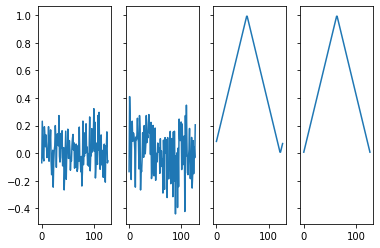

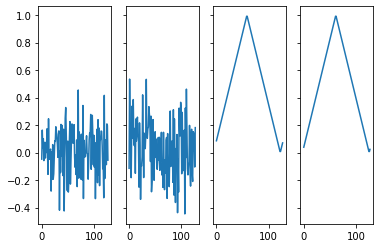

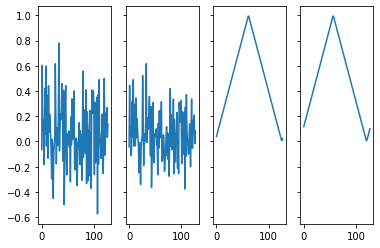

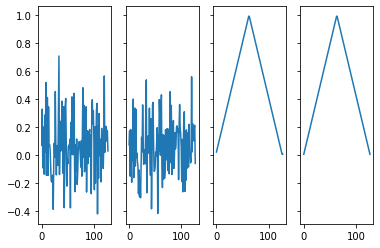

In [23]:
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
### 1D traiangle data generation ###
DisInputLength= 128
GenInputLenght =10
batch_size = 8
learning_rate = 5e-6 
num_training_iterations= 2000

def get_Gen_inp(InputLenght,batch):
	return np.random.rand(batch,InputLenght)

def get_Dist_real(Lenght,batch):
	normal_shift = (np.random.normal(0,5,batch)).astype(int)
	wave = signal.triang(Lenght)
	x_input = np.array([np.roll(wave,x) for x in normal_shift])
	return x_input

def build_Gen(GenInputLenght,DisInputLength):
  model = tf.keras.Sequential(\
  	[tf.keras.layers.Dense(4,input_shape=[GenInputLenght])\
  	,tf.keras.layers.Dense(8)\
  	,tf.keras.layers.Dense(16)\
    ,tf.keras.layers.Dense(32)\
    ,tf.keras.layers.Dense(50)\
  	,tf.keras.layers.Dense(75)\
  	,tf.keras.layers.Dense(DisInputLength)])
  return model

def build_Dis(DisInputLength):
  model = tf.keras.Sequential(\
  	[tf.keras.layers.Dense(75,input_shape=[DisInputLength])\
    ,tf.keras.layers.Dense(50)\
  	,tf.keras.layers.Dense(32)\
  	,tf.keras.layers.Dense(16)\
    ,tf.keras.layers.Dense(8)\
  	,tf.keras.layers.Dense(4)\
  	,tf.keras.layers.Dense(1,activation='sigmoid')])
  return model

Gen = build_Gen(GenInputLenght,DisInputLength)
Dis = build_Dis(DisInputLength)
optimizer_gen = tf.keras.optimizers.Adam(learning_rate)
optimizer_dis = tf.keras.optimizers.Adam(learning_rate)


checkpoint_dir_gen = './'
checkpoint_prefix = os.path.join(checkpoint_dir_gen, "my_ckpt_gen")

checkpoint_dir_dis = './'
checkpoint_prefix = os.path.join(checkpoint_dir_dis, "my_ckpt_dis")


def compute_loss(labels, pred):
	loss = tf.keras.losses.binary_crossentropy(labels, pred)
	return loss


@tf.function
def train_step_DisOnly( dis_real_x,dis_fake_x, dis_y): 
  with tf.GradientTape() as tape:
    x= tf.concat([dis_real_x,dis_fake_x],0)
    dis_pred = Dis(x)

    #print(tf.squeeze(dis_pred).numpy(),dis_y)
    loss = compute_loss(dis_y,tf.squeeze(dis_pred))

  #print(np.shape(loss_gen.numpy()),np.shape(loss_dis.numpy()))
  #print(loss_dis.numpy())
  grads = tape.gradient(loss, Dis.trainable_variables)
  optimizer_dis.apply_gradients(zip(grads, Dis.trainable_variables))

  return loss

def run_dif():
  hist =[]
  #### training ########
  for iter in range(num_training_iterations):
    dis_fake_x = get_Gen_inp(128,batch_size)
    dis_real_x = get_Dist_real(DisInputLength,batch_size)
    #other half of disc input is gen output
    dis_y = np.concatenate([np.ones(batch_size),np.zeros(batch_size)])
    loss = train_step_DisOnly(dis_real_x,dis_fake_x,dis_y)
    hist.append(loss)
    
    if(iter%500 == 0):
      print('Iter'+str(iter)+'loss:',loss.numpy().mean())
      inp1= get_Gen_inp(128,1)
      plt.plot(inp1[0])
      out = Dis(inp1)
      print('out1:',out)

      inp2= get_Dist_real(128,1)
      plt.plot(inp2[0])
      out = Dis(inp2)
      print('out2:',out)
      plt.pause(0.05)
  return hist

#hist = run_dif()



@tf.function
def train_step(gen_x, dis_real_x, dis_y,gen_y): 
  with tf.GradientTape() as tape:
    dis_fake_x = Gen(gen_x)
    dis_real_x = tf.cast(dis_real_x,tf.float32)
    x = tf.concat([dis_real_x,dis_fake_x],0)
    dis_pred = Dis(x)
    #print(tf.squeeze(dis_pred).numpy(),dis_y)
    loss_dis = compute_loss(dis_y,tf.squeeze(dis_pred))

  #print(np.shape(loss_gen.numpy()),np.shape(loss_dis.numpy()))
  #print(loss_dis.numpy())
  grads_dis = tape.gradient(loss_dis, Dis.trainable_variables)
  optimizer_dis.apply_gradients(zip(grads_dis, Dis.trainable_variables))
  
  with tf.GradientTape() as tape:
    gen_output = Gen(gen_x)
    dis_fake_out = Dis(gen_output)
    loss_gen = compute_loss(gen_y,tf.squeeze(dis_fake_out))

  grads_gen = tape.gradient(loss_gen, Gen.trainable_variables)
  optimizer_gen.apply_gradients(zip(grads_gen, Gen.trainable_variables))

  return loss_dis,loss_gen


def run_my_gan():
  hist_dis =[]
  hist_gen = []
  #### training ########
  for iter in range(num_training_iterations):
    gen_x = get_Gen_inp(GenInputLenght,batch_size)
    dis_real_x = get_Dist_real(DisInputLength,batch_size)
    #other half of disc input is gen output
    dis_y = np.concatenate([np.ones(batch_size),np.zeros(batch_size)])
    gen_y = np.ones(batch_size)

    loss_dis,loss_gen = train_step(gen_x,dis_real_x,dis_y,gen_y)
    hist_gen.append(loss_gen)
    hist_dis.append(loss_dis)
    if(iter%500 == 0):
      #print('Iter'+str(iter)+'loss:',loss.numpy().mean())
      out = Gen(get_Gen_inp(GenInputLenght,2))
      inp =  get_Dist_real(DisInputLength,2)
      fig,(ax1, ax2, x1, x2) = plt.subplots(1, 4, sharey=True)

      ax1.plot(out[0])
      ax2.plot(out[1])

      x1.plot(inp[0])
      x2.plot(inp[1])
      plt.pause(0.05)
  return hist_gen,hist_dis

h_g,h_d = run_my_gan()

# New Section

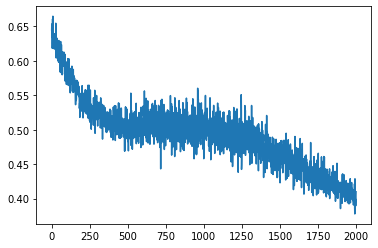

In [24]:

plt.plot(h_d)
#plt.plot(h_g)

tf.Tensor([[0.99999964]], shape=(1, 1), dtype=float32)


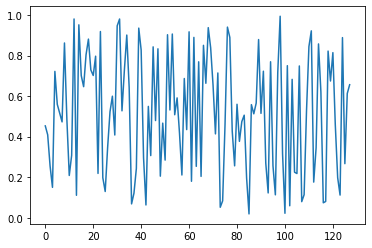

tf.Tensor([[0.9999962]], shape=(1, 1), dtype=float32)


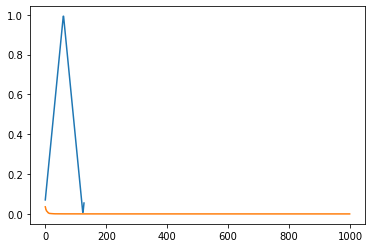

In [0]:
inp1 = get_Gen_inp(128,1)
plt.plot(inp1[0])
out = Dis(inp1)
print(out)
plt.pause(0.05)
inp2 = get_Dist_real(128,1)
plt.plot(inp2[0])
out = Dis(inp2)
print(out)
plt.plot(hist_dis)